# Mapping crimes in Boyle Heights

In [1]:
# https://github.com/dnanhkhoa/nb_black
%load_ext lab_black

### Import data tools

In [37]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import fiona
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
import altair_latimes as lat

alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Run if most-recent data is needed

In [3]:
# %run '00-lapd-crimes-processing.ipynb'

### Read crimes CSV downloaded from LA City data portal

In [4]:
crimes = pd.read_csv(
    "/Users/mhustiles/data/data/LA/crimes.csv",
    dtype={
        "area_name": str,
        "rpt_dist_no": str,
        "weapon_used_cd": str,
        "crm_cd": str,
        "premises_code": str,
        "division": str,
    },
)

### How many Part 1 crimes? 

In [5]:
len(crimes)

848719

### Boyle Heights spans across parts of three LAPD districts. Let's isolate the data frame to them for now

In [6]:
boyle_area_divisions = ["Central", "Hollenbeck", "Newton"]

In [7]:
boyle_heights_area_crimes = crimes[crimes["division_name"].isin(boyle_area_divisions)]

### How many Part 1 crimes are looking at now? 

In [8]:
len(boyle_heights_area_crimes)

109067

---

## Import mapping data

In [9]:
# Transform our crimes data into a geoDataFrame
boyle_heights_area_crimes_geo = gpd.GeoDataFrame(
    boyle_heights_area_crimes,
    geometry=gpd.points_from_xy(
        boyle_heights_area_crimes.longitude, boyle_heights_area_crimes.latitude
    ),
)

### Set the geographic file's coordinate reference system

In [10]:
boyle_heights_area_crimes_geo = boyle_heights_area_crimes_geo.set_crs("EPSG:4326")
boyle_heights_area_crimes_geo = boyle_heights_area_crimes_geo.set_crs(epsg=4326)

### Read LAPD reporting districts

In [11]:
districts = gpd.read_file("input/LAPD_Reporting_Districts/LAPD_Reporting_Districts.shp")

### Read LAPD divisions

In [12]:
divisions = gpd.read_file("input/LAPD_Divisions/LAPD_Divisions.shp")

### Read LA Times neighborhoods

In [13]:
hoods = gpd.read_file("input/custom-la-hoods-skid-row.geojson")

---

## Isolate just Boyle Heights crimes

### First, get the neighborhood boundary

In [14]:
boyle_heights = hoods[hoods["name"] == "Boyle Heights"]

### Next, get only those crimes within the boundaries by performing a spatial merge

In [15]:
bh_crimes = gpd.sjoin(
    boyle_heights_area_crimes_geo, boyle_heights, how="inner", op="within"
)

### Did it work? 

<AxesSubplot:>

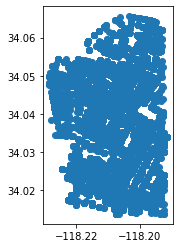

In [16]:
bh_crimes.plot()

### How many crimes now? 

In [17]:
len(bh_crimes)

17696

---

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [18]:
violations = (
    bh_crimes.groupby(["crime_code_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [19]:
violations.head(50)

,crime_code_description,total
40,Vehicle - stolen,4232
34,Theft plain - petty ($950 & under),2287
2,"Assault with deadly weapon, aggravated assault",1963
8,Burglary from vehicle,1759
31,Theft from motor vehicle - petty ($950 & under),1463
21,Robbery,1440
7,Burglary,1420
37,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",783
30,Theft from motor vehicle - grand ($400 and over),344
6,Brandish weapon,238


### Places where crimes occur?

In [20]:
places = (
    bh_crimes.groupby(["premises_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [21]:
places.head(5)

,premises_description,total
108,Street,7620
86,Parking lot,1683
104,Single family dwelling,1552
103,Sidewalk,944
80,Other business,893


### Aggregates for police geography

In [22]:
divisions = (
    bh_crimes.groupby(["division", "division_name", "crime_code_description", "year"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [23]:
divisions.head()

,division,division_name,crime_code_description,year,total
55,4.0,Hollenbeck,Vehicle - stolen,2020,711
4,4.0,Hollenbeck,"Assault with deadly weapon, aggravated assault",2020,335
11,4.0,Hollenbeck,Burglary,2020,243
48,4.0,Hollenbeck,Theft plain - petty ($950 & under),2020,215
45,4.0,Hollenbeck,Theft from motor vehicle - petty ($950 & under),2020,200


In [24]:
districts = (
    bh_crimes.groupby(
        ["reporting_district", "division_name", "crime_code_description", "year"]
    )
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [25]:
districts.head()

,reporting_district,division_name,crime_code_description,year,total
3522,497,Hollenbeck,Vehicle - stolen,2020,70
3515,497,Hollenbeck,Vehicle - stolen,2010,69
3640,499,Hollenbeck,Vehicle - stolen,2020,61
3517,497,Hollenbeck,Vehicle - stolen,2012,53
3520,497,Hollenbeck,Vehicle - stolen,2015,53


---

## Boyle Heights homicides

In [26]:
bh_homicides = bh_crimes[bh_crimes["crime_code_description"] == "Criminal homicide"]

<AxesSubplot:>

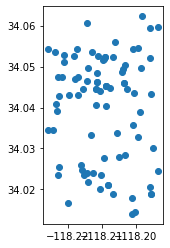

In [27]:
bh_homicides.plot()

In [28]:
bh_homicides.year.value_counts()

2020    20
2010    17
2011    12
2012    11
2014     9
2013     8
2016     4
2015     3
2021     2
Name: year, dtype: int64

### Plot the homicides by year

In [29]:
bh_homicides_yr = bh_homicides.groupby(["year"]).agg("size").reset_index(name="count")

In [30]:
bh_homicides_yr.year = bh_homicides_yr.year.astype(str)

In [31]:
lines = (
    alt.Chart(
        bh_homicides_yr,
        title="Boyle Heights homicides, by year",
    )
    .mark_bar()
    .encode(
        x=alt.X(
            "year:N",
            axis=alt.Axis(grid=False, title=""),
        ),
        y=alt.Y(
            "count:Q",
            scale=alt.Scale(domain=(0, 25)),
            axis=alt.Axis(
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
                tickCount=6,
                title="Homicides",
            ),
        ),
    )
)

# go
(lines).properties(height=400, width=800).configure_view(strokeOpacity=0)

alt.Chart(...)

---

## Export

In [32]:
bh_homicides.to_file("output/bh_homicides.geojson", driver="GeoJSON")

In [36]:
fiona.supported_drivers['KML'] = 'rw'
bh_homicides.to_file("output/bh_homicides.kml", driver="KML")

NameError: name 'fiona' is not defined

In [33]:
bh_homicides.to_csv("output/bh_homicides.csv", index=False)

In [34]:
boyle_heights_area_crimes.to_csv("input/boyle_heights_area_crimes.csv", index=False)